In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from os.path import join

plt.style.use(["seaborn", "thesis"])

/home/jcartus/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Prepare Dataset 

In [2]:
from SCFInitialGuess.utilities.dataset import extract_triu_batch, AbstractDataset

data_path = "../../dataset/TSmall_sto3g"
postfix = "TSmall_sto3g"
dim = 26

S = np.load(join(data_path, "S" + postfix + ".npy"))
P = np.load(join(data_path, "P" + postfix + ".npy"))
F = np.load(join(data_path, "F" + postfix + ".npy"))

index = np.load(join(data_path, "index" + postfix + ".npy"))

molecules = np.load(join(data_path, "molecules" + postfix + ".npy"))

def split(x, y, ind):
    return x[:ind], y[:ind], x[ind:], y[ind:]

S = np.load(join(data_path, "S" + postfix + ".npy"))
P = np.load(join(data_path, "P" + postfix + ".npy"))
F = np.load(join(data_path, "F" + postfix + ".npy"))

index = np.load(join(data_path, "index" + postfix + ".npy"))

molecules = np.load(join(data_path, "molecules" + postfix + ".npy"))



ind = int(0.8 * len(index))

s_triu = extract_triu_batch(S, dim)
p_triu = extract_triu_batch(P, dim)

s_triu_norm, mu, std = AbstractDataset.normalize(s_triu)


s_train, p_train, s_test, p_test = split(s_triu_norm, p_triu, ind)

# Test Utilities 

## Model generation 

In [3]:
dim_triu = dim * (dim + 1) // 2

In [4]:
intializer = keras.initializers.TruncatedNormal(mean=0.0, stddev=0.01)

def build_model(activation, structure, learning_rate):



    model = keras.Sequential()

    # input layer
    model.add(keras.layers.Dense(dim_triu, activation=activation, input_dim=dim_triu, kernel_initializer=intializer, bias_initializer='zeros'))

    # hidden
    for layer in structure:

        model.add(keras.layers.Dense(
                layer, 
                activation=activation, 
                kernel_initializer=intializer, 
                #bias_initializer='zeros',
                #kernel_regularizer=keras.regularizers.l2(1e-8)
        ))


    #output
    model.add(keras.layers.Dense(dim_triu))

    model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='MSE', metrics=['mae', 'mse'])
    
    return model

## Training 

In [8]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_mean_squared_error", 
    min_delta=1e-7, 
    patience=50, 
    verbose=1
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=10, 
    verbose=1, 
    mode='auto', 
    min_delta=1e-5, 
    cooldown=10, 
    min_lr=1e-10
)

In [9]:
n_tests = 5
n_resets = 3
epochs = 10000


def test_model(structure, activation, learning_rate=1e-4):
    error = []
    
    for i in range(n_tests):
        
        keras.backend.clear_session()
        model = build_model(activation, structure, learning_rate)
        
        for j in range(n_resets):
            keras.backend.set_value(model.optimizer.lr, learning_rate)
            
            history = model.fit(
                x = s_train,
                y = p_train,
                epochs=epochs,
                shuffle=True,
                validation_data=(s_test, p_test), 
                verbose=0, 
                callbacks=[
                    early_stopping, 
                    reduce_lr
                ]
            )
        
        error.append(np.min(history.history["val_mean_absolute_error"]))
        
        print(" - Test " + str(i+1) + ": " + str(error[-1]))
    
    return error

def run_layer_test_series(activation, structures, learning_rate):
    error = []
    for structure in structures:
        print("Layers: " + str(structure))
        error.append(test_model(structure, activation, learning_rate=learning_rate))
    return error

# Testing 

In [10]:
structures = [
        [dim_triu, dim_triu],
        [dim_triu, dim_triu, dim_triu],
        [dim_triu + 100, dim_triu + 100],
        [dim_triu + 250, dim_triu + 150, dim_triu + 50],
        #[dim_triu + 100, dim_triu + 200, dim_triu + 100],
        #[dim_triu * 2]
    ]
        
learning_rates = [1e-3, 1e-4, 1e-5]

In [11]:
res = []
for lr in learning_rates:
    print("# lr" + str(lr))
    res.append(run_layer_test_series('elu', structures, lr))

# lr0.001
Layers: [351, 351]

Epoch 00067: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00091: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00110: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00129: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 00148: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 00167: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 00186: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Epoch 00205: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.

Epoch 00224: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.

Epoch 00243: ReduceLROnPlateau reducing learning rate to 9.765625463842298e-07.

Epoch 00262: ReduceLROnPlateau reducing learning rate to 4.882812731921149e-07.

Epoch 00281: ReduceLROnPlateau reducing learning rate to 2.4414063659605745e-0


Epoch 00235: ReduceLROnPlateau reducing learning rate to 9.765625463842298e-07.

Epoch 00254: ReduceLROnPlateau reducing learning rate to 4.882812731921149e-07.

Epoch 00273: ReduceLROnPlateau reducing learning rate to 2.4414063659605745e-07.
Epoch 00291: early stopping

Epoch 00056: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00075: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00094: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00113: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 00132: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 00151: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 00170: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Epoch 00189: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.

Epoch 00208: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06


Epoch 00147: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 00166: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 00185: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 00210: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Epoch 00229: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.

Epoch 00248: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.

Epoch 00267: ReduceLROnPlateau reducing learning rate to 9.765625463842298e-07.

Epoch 00286: ReduceLROnPlateau reducing learning rate to 4.882812731921149e-07.

Epoch 00305: ReduceLROnPlateau reducing learning rate to 2.4414063659605745e-07.

Epoch 00324: ReduceLROnPlateau reducing learning rate to 1.2207031829802872e-07.
Epoch 00333: early stopping

Epoch 00087: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00116: ReduceLROnPlateau reducing learning rate to 0.000250000011874362


Epoch 00151: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 00170: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 00189: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Epoch 00208: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.

Epoch 00227: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.

Epoch 00246: ReduceLROnPlateau reducing learning rate to 9.765625463842298e-07.

Epoch 00265: ReduceLROnPlateau reducing learning rate to 4.882812731921149e-07.

Epoch 00284: ReduceLROnPlateau reducing learning rate to 2.4414063659605745e-07.

Epoch 00303: ReduceLROnPlateau reducing learning rate to 1.2207031829802872e-07.

Epoch 00322: ReduceLROnPlateau reducing learning rate to 6.103515914901436e-08.

Epoch 00341: ReduceLROnPlateau reducing learning rate to 3.051757957450718e-08.
Epoch 00349: early stopping

Epoch 00057: ReduceLROnPlateau reducing learning rate to 0.00050000002374872


Epoch 00249: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00268: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 00287: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 00306: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 00325: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Epoch 00344: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.

Epoch 00363: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.

Epoch 00382: ReduceLROnPlateau reducing learning rate to 9.765625463842298e-07.

Epoch 00401: ReduceLROnPlateau reducing learning rate to 4.882812731921149e-07.

Epoch 00420: ReduceLROnPlateau reducing learning rate to 2.4414063659605745e-07.

Epoch 00439: ReduceLROnPlateau reducing learning rate to 1.2207031829802872e-07.

Epoch 00458: ReduceLROnPlateau reducing learning rate to 6.103515914901436e-08.

Epoch 00477: ReduceLROnP


Epoch 00183: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Epoch 00202: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.

Epoch 00221: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.

Epoch 00240: ReduceLROnPlateau reducing learning rate to 9.765625463842298e-07.

Epoch 00259: ReduceLROnPlateau reducing learning rate to 4.882812731921149e-07.

Epoch 00278: ReduceLROnPlateau reducing learning rate to 2.4414063659605745e-07.

Epoch 00297: ReduceLROnPlateau reducing learning rate to 1.2207031829802872e-07.
Epoch 00298: early stopping

Epoch 00085: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00109: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00128: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00147: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 00166: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05


Epoch 00220: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.

Epoch 00239: ReduceLROnPlateau reducing learning rate to 9.765625463842298e-07.

Epoch 00258: ReduceLROnPlateau reducing learning rate to 4.882812731921149e-07.

Epoch 00277: ReduceLROnPlateau reducing learning rate to 2.4414063659605745e-07.

Epoch 00296: ReduceLROnPlateau reducing learning rate to 1.2207031829802872e-07.

Epoch 00315: ReduceLROnPlateau reducing learning rate to 6.103515914901436e-08.
Epoch 00332: early stopping

Epoch 00079: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00101: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00120: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00139: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 00158: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 00177: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-0


Epoch 00170: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.

Epoch 00189: ReduceLROnPlateau reducing learning rate to 9.765625463842298e-07.
Epoch 00192: early stopping
 - Test 2: 0.06064464111084962

Epoch 00077: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00102: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00131: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00156: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 00175: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 00194: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 00213: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Epoch 00232: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.

Epoch 00251: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.

Epoch 00270: ReduceLROnPlateau reducing learnin


Epoch 00176: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00202: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 00223: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 00251: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 00273: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Epoch 00301: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.

Epoch 00320: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.

Epoch 00339: ReduceLROnPlateau reducing learning rate to 9.765625463842298e-07.

Epoch 00365: ReduceLROnPlateau reducing learning rate to 4.882812731921149e-07.

Epoch 00384: ReduceLROnPlateau reducing learning rate to 2.4414063659605745e-07.

Epoch 00403: ReduceLROnPlateau reducing learning rate to 1.2207031829802872e-07.

Epoch 00422: ReduceLROnPlateau reducing learning rate to 6.103515914901436e-08.

Epoch 00441: ReduceLROnP


Epoch 00233: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

Epoch 00252: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.

Epoch 00271: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.

Epoch 00290: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.

Epoch 00309: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-07.

Epoch 00328: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-07.

Epoch 00347: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-07.

Epoch 00366: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-08.

Epoch 00385: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-08.

Epoch 00411: ReduceLROnPlateau reducing learning rate to 2.4414061883248905e-08.

Epoch 00430: ReduceLROnPlateau reducing learning rate to 1.2207030941624453e-08.

Epoch 00449: ReduceLROnPlateau reducing learning rate to 6.103515470812226e-09.
Epoch 00463: early stopping




Epoch 00085: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.

Epoch 00104: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.

Epoch 00123: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.

Epoch 00142: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-07.

Epoch 00161: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-07.

Epoch 00180: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-07.

Epoch 00199: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-08.

Epoch 00218: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-08.
Epoch 00221: early stopping
 - Test 5: 0.0057823209865806415
Layers: [351, 351, 351]

Epoch 00218: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 00284: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 00303: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

Epoch 00322: ReduceLROnPla


Epoch 00104: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.

Epoch 00123: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.

Epoch 00147: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.

Epoch 00166: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-07.

Epoch 00185: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-07.

Epoch 00204: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-07.

Epoch 00223: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-08.

Epoch 00242: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-08.

Epoch 00261: ReduceLROnPlateau reducing learning rate to 2.4414061883248905e-08.
Epoch 00272: early stopping

Epoch 00033: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 00052: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 00074: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

E


Epoch 00257: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.

Epoch 00276: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.

Epoch 00295: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-07.

Epoch 00314: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-07.

Epoch 00333: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-07.

Epoch 00352: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-08.

Epoch 00371: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-08.

Epoch 00390: ReduceLROnPlateau reducing learning rate to 2.4414061883248905e-08.

Epoch 00409: ReduceLROnPlateau reducing learning rate to 1.2207030941624453e-08.
Epoch 00411: early stopping

Epoch 00021: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 00040: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 00059: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.



Epoch 00114: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.

Epoch 00133: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-07.

Epoch 00152: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-07.

Epoch 00171: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-07.

Epoch 00190: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-08.

Epoch 00209: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-08.
Epoch 00217: early stopping
 - Test 3: 0.005401377137565049

Epoch 00172: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 00200: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 00219: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

Epoch 00238: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.

Epoch 00257: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.

Epoch 00276: ReduceLROnPlateau reducing learning ra


Epoch 00207: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-08.

Epoch 00226: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-08.

Epoch 00245: ReduceLROnPlateau reducing learning rate to 2.4414061883248905e-08.
Epoch 00246: early stopping

Epoch 00023: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 00042: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 00067: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

Epoch 00086: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.

Epoch 00105: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.

Epoch 00124: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.

Epoch 00143: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-07.

Epoch 00162: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-07.

Epoch 00181: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-07.

E

Epoch 00445: early stopping

Epoch 00022: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 00041: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 00060: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

Epoch 00079: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.

Epoch 00098: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.

Epoch 00117: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.

Epoch 00136: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-07.

Epoch 00164: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-07.

Epoch 00183: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-07.

Epoch 00202: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-08.

Epoch 00221: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-08.
Epoch 00235: early stopping

Epoch 00025: ReduceLROnPlateau reducing learning rate t


Epoch 00754: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-08.

Epoch 00773: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-09.

Epoch 00792: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-09.

Epoch 00811: ReduceLROnPlateau reducing learning rate to 2.4414061883248905e-09.
Epoch 00823: early stopping

Epoch 00011: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.

Epoch 00030: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.

Epoch 00049: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-06.

Epoch 00068: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-07.

Epoch 00087: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-07.

Epoch 00106: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-07.

Epoch 00125: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-08.

Epoch 00144: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-08.

E

Epoch 00214: early stopping
 - Test 4: 0.010989936300326342

Epoch 00580: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.

Epoch 00599: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.

Epoch 00618: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-06.

Epoch 00637: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-07.

Epoch 00656: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-07.

Epoch 00675: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-07.

Epoch 00703: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-08.

Epoch 00722: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-08.

Epoch 00741: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-08.

Epoch 00760: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-09.

Epoch 00779: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-09.

Epoch 00798: ReduceLROnPlateau reducing learning ra


Epoch 00070: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-06.

Epoch 00089: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-07.

Epoch 00108: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-07.

Epoch 00127: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-07.

Epoch 00146: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-08.

Epoch 00165: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-08.

Epoch 00184: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-08.

Epoch 00203: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-09.

Epoch 00222: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-09.
Epoch 00234: early stopping
 - Test 2: 0.012078599346366094

Epoch 00792: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.

Epoch 00820: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.

Epoch 00842: ReduceLROnPlateau reducing learning ra


Epoch 00153: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-08.

Epoch 00172: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-08.

Epoch 00191: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-09.

Epoch 00210: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-09.

Epoch 00229: ReduceLROnPlateau reducing learning rate to 2.4414061883248905e-09.
Epoch 00229: early stopping

Epoch 00015: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.

Epoch 00034: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.

Epoch 00055: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-06.

Epoch 00074: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-07.

Epoch 00093: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-07.

Epoch 00112: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-07.

Epoch 00131: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-08.

E

Epoch 00747: early stopping

Epoch 00021: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.

Epoch 00040: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.

Epoch 00061: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-06.

Epoch 00080: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-07.

Epoch 00099: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-07.

Epoch 00118: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-07.

Epoch 00137: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-08.

Epoch 00156: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-08.

Epoch 00175: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-08.

Epoch 00194: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-09.

Epoch 00213: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-09.
Epoch 00213: early stopping

Epoch 00011: ReduceLROnPlateau reducing learning rate t


Epoch 00775: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-08.

Epoch 00794: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-08.

Epoch 00813: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-08.

Epoch 00832: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-09.

Epoch 00851: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-09.

Epoch 00870: ReduceLROnPlateau reducing learning rate to 2.4414061883248905e-09.

Epoch 00889: ReduceLROnPlateau reducing learning rate to 1.2207030941624453e-09.

Epoch 00908: ReduceLROnPlateau reducing learning rate to 6.103515470812226e-10.
Epoch 00910: early stopping

Epoch 00021: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.

Epoch 00040: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.

Epoch 00059: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-06.

Epoch 00078: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-07.


Epoch 00096: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-07.

Epoch 00115: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-07.

Epoch 00134: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-08.

Epoch 00153: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-08.

Epoch 00172: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-08.

Epoch 00191: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-09.

Epoch 00210: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-09.
Epoch 00218: early stopping
 - Test 3: 0.011466393071175808

Epoch 00685: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.

Epoch 00714: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.

Epoch 00742: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-06.

Epoch 00761: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-07.

Epoch 00780: ReduceLROnPlateau reducing learning ra

In [12]:
x = [ 
    s for s in range(len(structures)) for i in range(n_tests)
]

In [13]:
def structure_string(structure):
    return "_".join(list(map(str,list(structure))))
structure_string(structures[0])

'351_351'

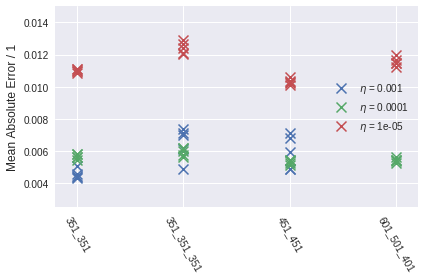

In [18]:
for r, lr in zip(res, learning_rates):
    plt.scatter(x, np.array(r).flatten(), marker="x", label="$\eta$ = " + str(lr) )

#plt.xlabel("Number of Hidden Layers / 1")
plt.ylabel("Mean Absolute Error / 1")

plt.xticks(
    np.arange(len(structures)),
    [structure_string(structure) for structure in structures],
    rotation=-60
)

plt.ylim(0.0025, 0.015)

plt.legend()
plt.tight_layout()

plt.savefig("/home/jcartus/Repos/MastersThesis/SMatrixDescriptor/figures/HyperparameterStudy.pdf")

plt.show()

In [64]:
(5e-3)**2

2.5e-05